In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from six import StringIO  
from sklearn.tree import plot_tree, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, precision_score, mean_squared_error

# Visualisation libraries

## Text
from colorama import Fore, Back, Style
from IPython.display import Image, display, Markdown, Latex

## graphviz
import graphviz 

## seaborn
import seaborn as sns
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":14,"axes.labelsize":12})
sns.set_style("whitegrid")

## matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Polygon
import matplotlib.gridspec as gridspec
plt.style.use('seaborn-whitegrid')
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'
%matplotlib inline

## plotly
from plotly.offline import init_notebook_mode, iplot 
import plotly.graph_objs as go
import plotly.offline as py
from plotly.subplots import make_subplots
import plotly.express as px
# Graphics in retina format 
%config InlineBackend.figure_format = 'retina' 

## pydot
import pydot

import warnings
warnings.filterwarnings("ignore")

# Bagging, Random Forests, Boosting

We would like to define a function that summarized our regressor tree. This can be done using the following packages.

| Package | Description |
|---------------------------------------------------------------------------------------------------------------------|--------------------------------------------|
| [sklearn.tree.export_graphviz](https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html) | Exports a decision tree in the DOT format. |
| [StringIO](https://six.readthedocs.io/) | io.StringIO in Python 3 |
| [pydot](https://github.com/pydot/pydot) | Visualizes the graph |

In [2]:
def Tree_Graph(Estimator, Features, class_names = None, fill=True):
    dot_data = StringIO()
    export_graphviz(Estimator, out_file = dot_data, feature_names = Features, class_names = class_names, filled = fill)
    graph, = pydot.graph_from_dot_data(dot_data.getvalue())
    graph = Image(graph.create_png())
    display(graph)

## Bagging

The decision trees can **suffer from high variance**. In other words, if we split the training data into two parts at random, and fit a decision tree to both halves, the results that we get could be **quite different**.

Here, we calculate $\hat{f^1}(x)$, $\hat{f^2}(x)$, $\ldots$, $\hat{f^B}(x)$ using B separate training sets, and average them in order to obtain a single **low-variance** statistical learning model, given by

$$\hat{f}_{\mbox{avg}}(x) = \frac{1}{B}\sum_{b=1}^{B} \hat{f^b}(x)$$

Of course, this is not practical because we generally do not have access to multiple training sets. Instead, we can bootstrap, by taking repeated samples from the (single) training data set. In this approach we generate B different bootstrapped training data sets. We then train our method on the bth bootstrapped training set in order to get $\hat{f^{*b}}(x)$, and finally average
all the predictions, to obtain

$$\hat{f}_{\mbox{bag}}(x) = \frac{1}{B}\sum_{b=1}^{B} \hat{f^{*b}}(x)$$

This is called **bagging**.

## Random Forests

Random forests provide an improvement over bagged trees by way of a random forest small tweak that decorrelates the trees. As in bagging, we build a number of decision trees on bootstrapped training samples. But when building these decision trees, each time a split in a tree is considered, a random sample of m predictors is chosen as split candidates from the full set of p predictors.

## Boosting

Boosting is described in **Alogrithm 8.2** of the [**textbook**](https://link.springer.com/book/10.1007/978-1-4614-7138-7) as follows,

1. Set $\hat{f}(x)$ = 0 and $r_i = y_i$ for all $i$ in the training set.
2. For b = 1, 2, . . . , B, repeat:
    * (a) Fit a tree $\hat{f^b}(x)$ with $d$ splits ($d$ + 1 terminal nodes) to the training data $(X,~r)$.
    * (b) Update $\hat{f}$ by adding in a shrunken version of the new tree:
$$$\hat{f}(x) \leftarrow \hat{f}(x) + \lambda \hat{f^b}(x).$$
    * (c) Update the residuals,
$$r_i \leftarrow r_i - \lambda \hat{f^b}(x_i).$$
3. Output the boosted model,
$$\hat{f}(x) = \sum_{b=1}^{B} \lambda\hat{f^b}(x).$$

# LAB

## Bagging and Random Forests

<div class="alert alert-block alert-info">
<font size="+2"><b>Boston Dataset</b></font>
</div>

This dataset can be extracted from the [**MASS library**](https://cran.r-project.org/web/packages/MASS/) using the following syntax.
```R
library (MASS)
write.csv(Boston, "Boston.csv")
```

This dataset is part of the [scikit-learn datasets](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html) and can be accessed using the following syntax.
```Python
from sklearn.datasets import load_boston
```

In [3]:
Boston = pd.read_csv('Data/Boston.csv').drop('Unnamed: 0', axis=1).dropna()
Boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [4]:
X = Boston.drop('medv', axis=1)
y = Boston.medv

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

### Bagging: using all features

MSE= 16.18


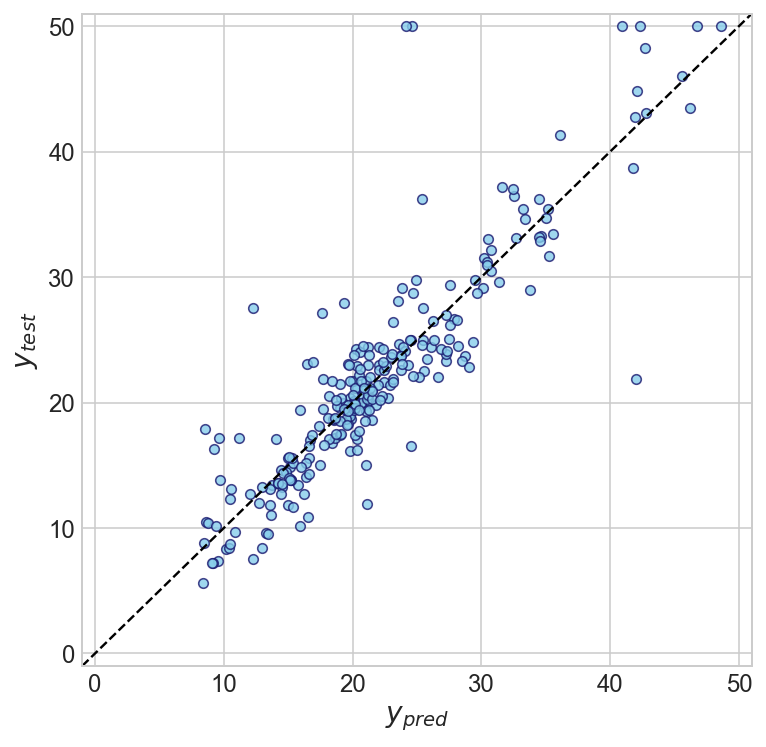

In [5]:
reg = RandomForestRegressor(max_features=13, random_state=1)
_ = reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print(Back.CYAN + Fore.BLACK + Style.BRIGHT + 'MSE' + Style.RESET_ALL + '= %.2f' % mean_squared_error(y_test, y_pred))

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
_ = ax.scatter(y_pred, y_test, label='medv', facecolors='SkyBlue', edgecolors='MidnightBlue', alpha = 0.8)
_ = ax.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
_ = ax.set_xlabel(r'$y_{pred}$')
_ = ax.set_ylabel(r'$y_{test}$')
_ = ax.set_xlim([-1,51])
_ = ax.set_ylim([-1,51])

### Random forests: using only 6 features

MSE= 15.82


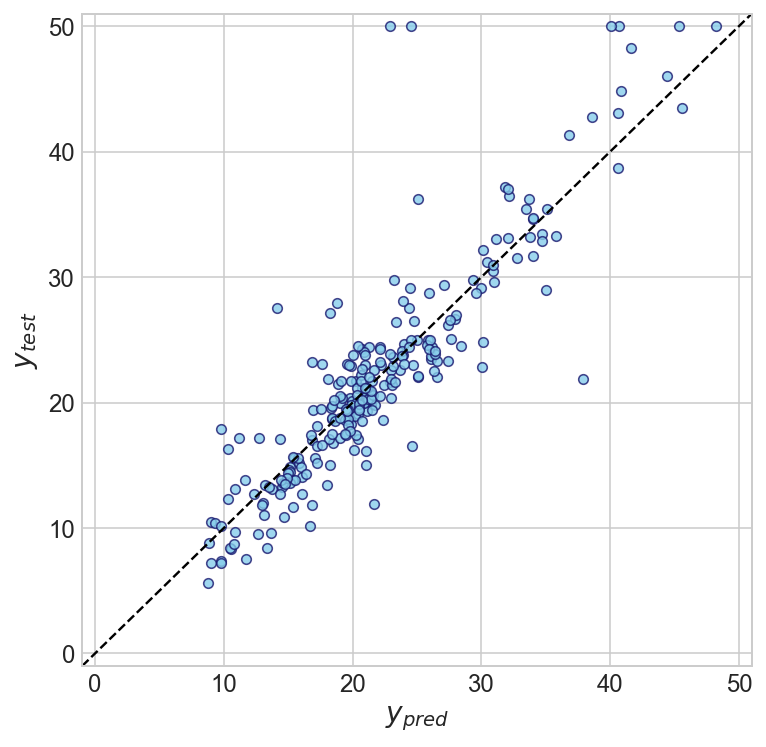

In [6]:
reg = RandomForestRegressor(max_features=6, random_state=1)
_ = reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print(Back.CYAN + Fore.BLACK + Style.BRIGHT + 'MSE' + Style.RESET_ALL + '= %.2f' % mean_squared_error(y_test, y_pred))

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
_ = ax.scatter(y_pred, y_test, label='medv', facecolors='SkyBlue', edgecolors='MidnightBlue', alpha = 0.8)
_ = ax.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
_ = ax.set_xlabel(r'$y_{pred}$')
_ = ax.set_ylabel(r'$y_{test}$')
_ = ax.set_xlim([-1,51])
_ = ax.set_ylim([-1,51])

In [7]:
Importance = pd.DataFrame({'Importance':reg.feature_importances_*100}, index=X.columns)
display(Importance.style.background_gradient(cmap='PuBu',subset=['Importance']).set_precision(2))

,Importance
crim,4.73
zn,0.43
indus,3.80
chas,0.18
nox,4.43
rm,29.05
age,2.64
dis,5.91
rad,0.42
tax,2.73


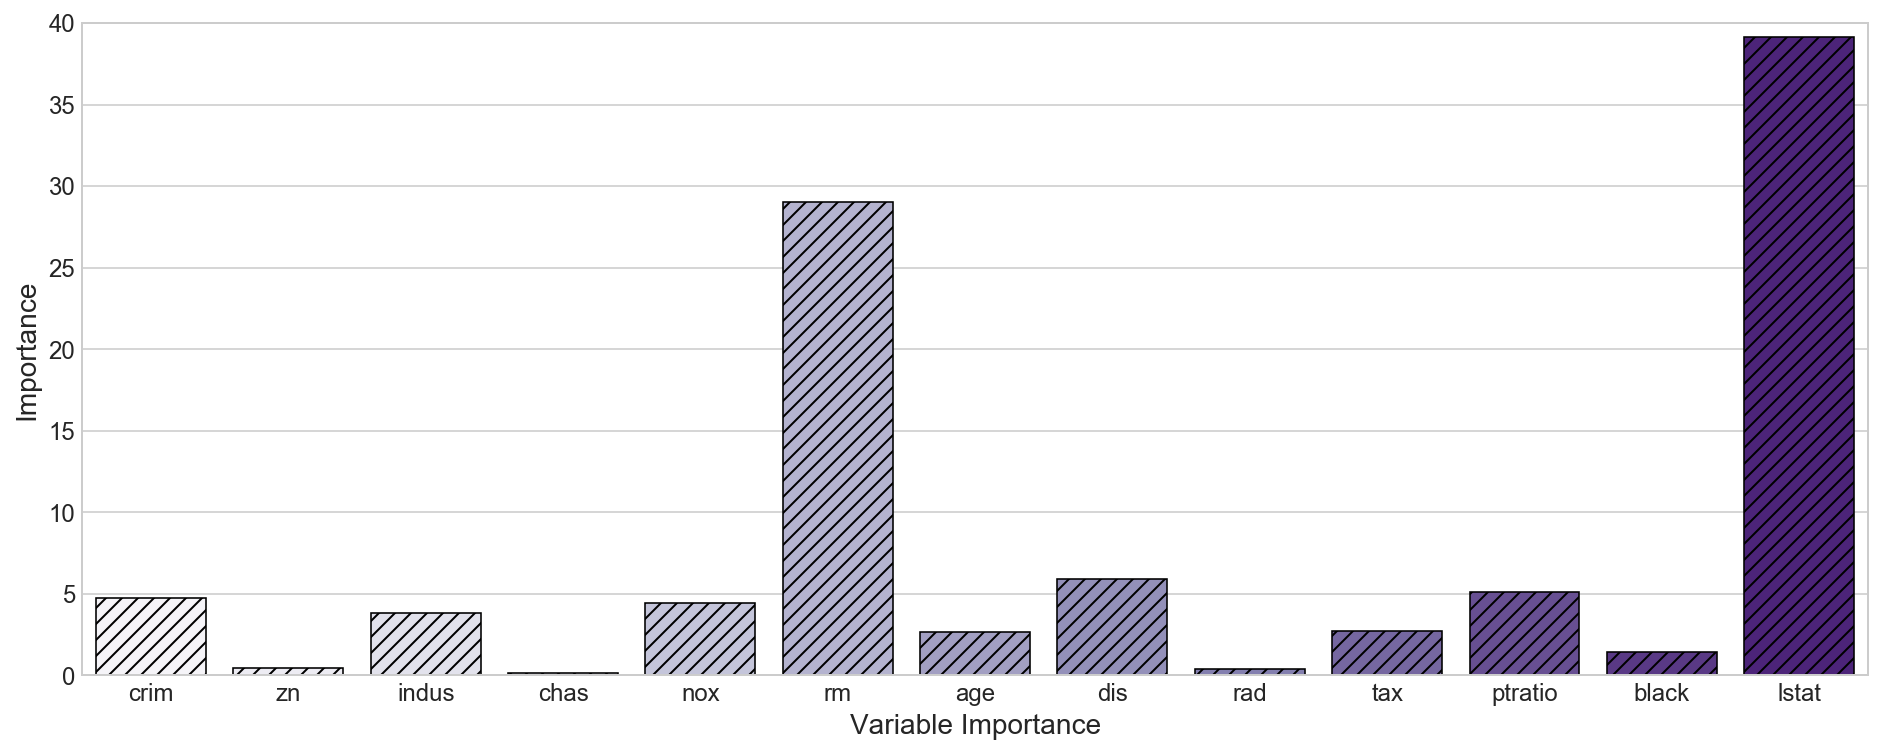

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
_ = sns.barplot(ax = ax, x=Importance.index, y= Importance.Importance, palette='Purples',
                edgecolor='k',  hatch="///")
_ = ax.set_xlabel('Variable Importance')
_ = ax.set_ylim([0, 40])

### Boosting

MSE= 15.59


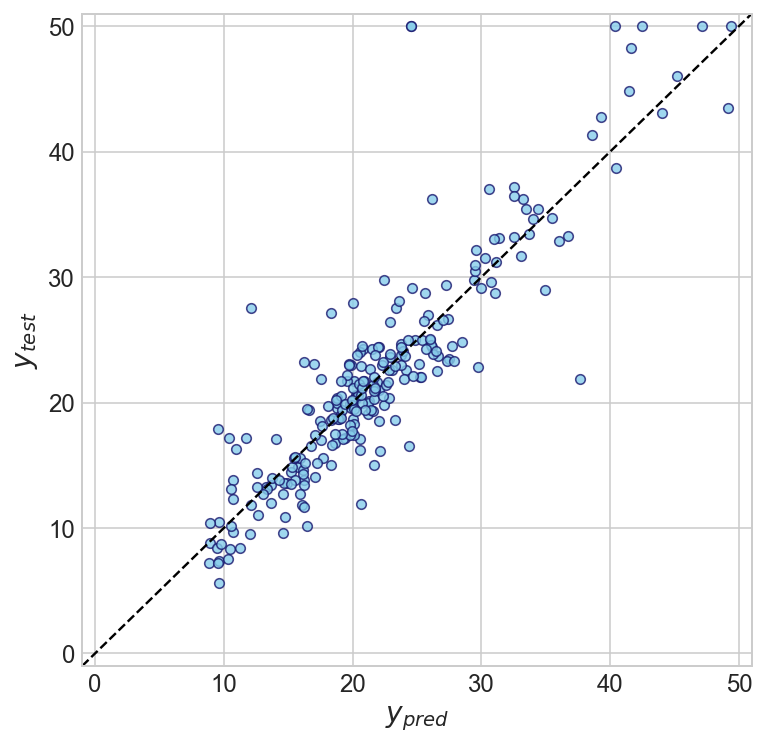

In [9]:
reg = GradientBoostingRegressor(n_estimators=500, learning_rate=0.01, random_state=1)
_ = reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print(Back.CYAN + Fore.BLACK + Style.BRIGHT + 'MSE' + Style.RESET_ALL + '= %.2f' % mean_squared_error(y_test, y_pred))

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
_ = ax.scatter(y_pred, y_test, label='medv', facecolors='SkyBlue', edgecolors='MidnightBlue', alpha = 0.8)
_ = ax.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
_ = ax.set_xlabel(r'$y_{pred}$')
_ = ax.set_ylabel(r'$y_{test}$')
_ = ax.set_xlim([-1,51])
_ = ax.set_ylim([-1,51])

In [10]:
Importance = pd.DataFrame({'Importance':reg.feature_importances_*100}, index=X.columns)
display(Importance.style.background_gradient(cmap='PuBu',subset=['Importance']).set_precision(2))

,Importance
crim,2.80
zn,0.01
indus,0.58
chas,0.12
nox,0.73
rm,27.93
age,0.92
dis,5.90
rad,0.15
tax,1.10


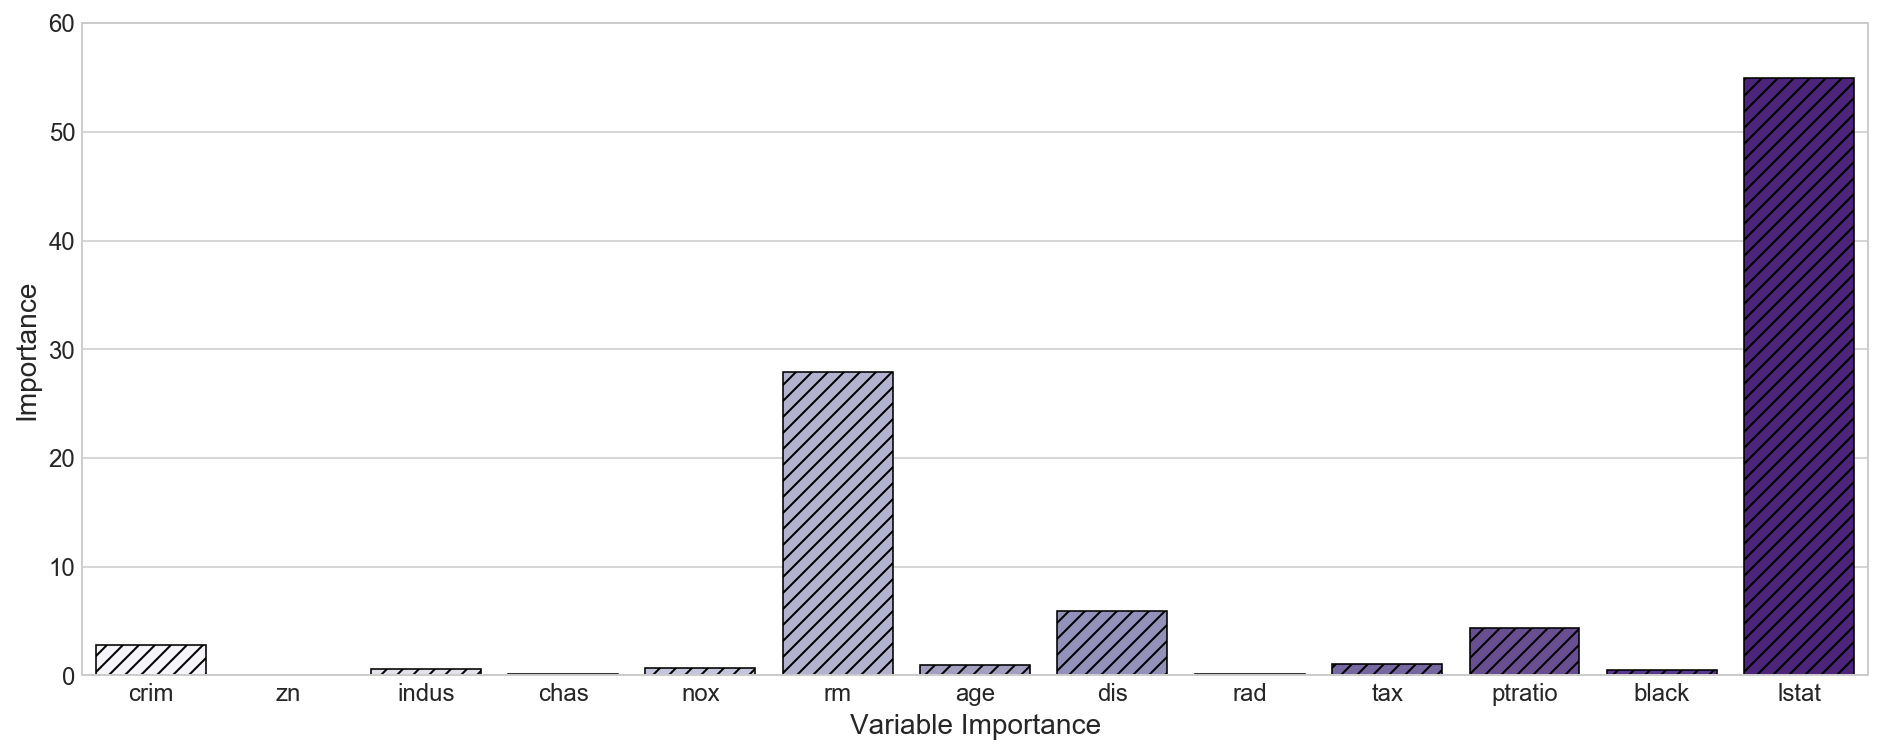

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
_ = sns.barplot(ax = ax, x=Importance.index, y= Importance.Importance, palette='Purples',
                edgecolor='k',  hatch="///")
_ = ax.set_xlabel('Variable Importance')
_ = ax.set_ylim([0, 60])

***

## Refrences

* James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). [An introduction to statistical learning](https://link.springer.com/book/10.1007/978-1-4614-7138-7) (Vol. 112, pp. 3-7). New York: springer.

* Jordi Warmenhoven, [ISLR-python](https://github.com/JWarmenhoven/ISLR-python)
* James, G., Witten, D., Hastie, T., & Tibshirani, R. (2017). [ISLR: Data for an Introduction to Statistical Learning with Applications in R](https://cran.r-project.org/web/packages/ISLR/index.html)

***